# Autoencoder

In [1]:
!pip install seaborn

You should consider upgrading via the '/home/lparolari/Projects/har/.venv/bin/python -m pip install --upgrade pip' command.


Set some global parameters

In [2]:
# Whether to rotate data in an orientation indiepndent manner.
# Default: True
USE_ORIENTATION_INDIPENDENT_TRANSFORMATION = True

# Whether to normalize data.
# Note: we usually do not normalize beacause the distance between points
# and reconstructed points gets reduced but the signal is not well represented
# Default: False
USE_NORMALIZATION = False

# Whether to center accelerometer data.
# Note: we tryed centering accelerometer data to check autoencoder behaviour with CNN center data.
# Default: False
USE_CENTERING_ACC = False

# Whether to low-pass filter data.
# Default: False
USE_LOW_PASS_FILTER = False

# Whether to use Bryan dataset as validation dataset.
# Default: False
USE_BRYAN_VALIDATION_DATASET = True

# Whether to use all positions (right, left, back, top, hand, pocket) from Bryan dataset.
# Default: Flase
USE_ALL_POSITION_BRYAN_DATASET = True

In [3]:
def get_settings():
    """
    Return a string which encodes current global settings.
    Can be used as name of files.
    """
    oit = "_oit" if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION else ""
    norm = "_norm" if USE_NORMALIZATION else ""
    bryan = "_bryan" if USE_BRYAN_VALIDATION_DATASET else ""
    allpos = "_allpos" if USE_BRYAN_VALIDATION_DATASET and USE_ALL_POSITION_BRYAN_DATASET else ""
    return oit + norm + bryan + allpos

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers

from autoencoder_utils import show_samples, show_loss, show_mse, show_reconstructed_signals, show_reconstruction_errors
from keras_utils import ModelSaveCallback
from orientation_indipendend_transformation import orientation_independent_transformation

In [5]:
random.seed(42)
np.random.seed(42)

## Load dataset

In [6]:
def load_dataset(data_filename="dataset.csv", label_filename="labels.csv", dataset_dir="./datasets"):
    data = pd.read_csv(os.path.join(dataset_dir, data_filename), header=None)
    labels = pd.read_csv(os.path.join(dataset_dir, label_filename), header=None, names=["user", "model", "label"])

    return data, labels


def load_dataset_position(data_filename="dataset.csv", label_filename="labels.csv", dataset_dir="./datasets"):
    data = pd.read_csv(os.path.join(dataset_dir, data_filename), header=None)
    labels = pd.read_csv(os.path.join(dataset_dir, label_filename), header=None, names=["user", "model", "label", "position"])

    return data, labels

In [7]:
def print_stats(ds: pd.DataFrame):
    print("Shape", ds.shape)
    print("Columns", ds.columns)

In [8]:
X_df_reference, y_df_reference = load_dataset(dataset_dir="./datasets/heterogeneity_f50_w2.5_o0.5")
X_df_reference_validation, y_df_reference_validation = load_dataset_position(dataset_dir="./datasets/bryan_f50_w2.5_o0.5")

In [9]:
print_stats(X_df_reference)
print_stats(y_df_reference)
print_stats(X_df_reference_validation)
print_stats(y_df_reference_validation)

Shape (46657, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (46657, 3)
Columns Index(['user', 'model', 'label'], dtype='object')
Shape (4790, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (4790, 4)
Columns Index(['user', 'model', 'label', 'position'], dtype='object')


## Preprocessing

In [10]:
def to_numpy(df):
    return df.loc[:].to_numpy()

In [11]:
def get_label(x):
    return x[..., 2]

In [12]:
def restructure(x):
    return x.reshape(-1, 6, 125)

In [13]:
def normalize(x):
    min_val = np.max(x)
    max_val = np.min(x)
    
    x = (x - min_val) / (max_val - min_val)
    
    return x

In [14]:
def center(x):
    means = np.mean(x, axis=2)  # get mean for each dimension for each window
    means[:, 3:] = 0  # do not center gyroscope
    x = (x - means[:,:,np.newaxis])

    return x

In [15]:
from scipy.signal import butter, filtfilt, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [16]:
def plot_butter_lowpass_filter(cutoff, fs, order):
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    # Plot the frequency response.
    w, h = freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()

In [17]:
def get_X(df, use_low_pass_filter=False, use_normalization=False, use_orientation_indipendent_transformation=False, use_centering=False):
    """
    Return a numpy array with preprocessed X data
    """
    # 1. Back to numpy
    a = to_numpy(df)

    # 2. Restructure the array
    a = restructure(a)

    # Low-pass filter
    if use_low_pass_filter or USE_LOW_PASS_FILTER:
        for i in range(len(a)):
            window = a[i]
            lowpassed = [butter_lowpass_filter(window[j], cutoff=5, fs=50) for j in range(6)]
            a[i] = lowpassed

    # 3. Normalize
    if use_normalization or USE_NORMALIZATION:
        a = normalize(a)
        
    # 4. Orientation indipendent transformation
    if use_orientation_indipendent_transformation or USE_ORIENTATION_INDIPENDENT_TRANSFORMATION:
        a = orientation_independent_transformation(a)

    # 4. Center accelerometer data
    if use_centering or USE_CENTERING_ACC:
        a = center(a)
    
    return a


def get_y(df):
    """
    Return a numpy array with labels
    """
    y = to_numpy(df)
    y = get_label(y)
    return y


def get_y_pos(df):
    """
    Return a numpy array with labels
    """
    y = to_numpy(df)
    y = y[..., 3]
    return y


def get_y_hot(df):
    """
    Return a numpy array with labels in one-hot encoding
    """
    return pd.get_dummies(df['label']).to_numpy()

### Training Set

In [18]:
X_df, y_df = X_df_reference.copy(), y_df_reference.copy()

Set up the low-pass filter

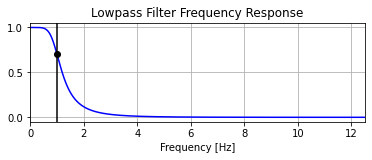

In [19]:
cutoff = 1  # desired cutoff frequency of the filter, Hz
fs = 25     # sample rate, Hz
order = 3

plot_butter_lowpass_filter(cutoff, fs, order)
plt.show()

Prepare the dataset with pandas
* split training and test set
* shuffle the dataset

In [20]:

# *** MERGE LABELS
# Merge sit and stand labels
sit_or_stand_filter = (y_df["label"] == "sit") | (y_df["label"] == "stand")
y_df["label"].loc[sit_or_stand_filter] = "no_activity"

# Merge stairs activity
#stairsdown_or_stairsup_filter = (y_df["label"] == "stairsdown") | (y_df["label"] == "stairsup")
#y_df["label"].loc[stairsdown_or_stairsup_filter] = "stairs"

# *** SHUFFLE
X_shuffled_df = X_df.sample(frac=1)
y_shuffled_df = y_df.reindex(X_shuffled_df.index)

# *** TRAIN AND TEST
if USE_BRYAN_VALIDATION_DATASET:
    but_last_user_indicies = ~(y_df['user'] == "z")
else:
    but_last_user_indicies = ~((y_df['user'] == "a") | (y_df['user'] == "b"))

X_train_df = X_shuffled_df.loc[but_last_user_indicies]
X_test_df = X_shuffled_df.loc[~but_last_user_indicies]

y_train_df = y_shuffled_df.loc[but_last_user_indicies]
y_test_df = y_shuffled_df.loc[~but_last_user_indicies]

print("X_train_df =", len(X_train_df))
print("X_test_df =", len(X_test_df))
print("y_train_df =", len(y_train_df))
print("y_test_df =", len(y_test_df))

assert len(X_train_df) == len(y_train_df), "X train and y train do not contain same number of samples"
assert len(X_test_df) == len(y_test_df), "X test and y test do not contain same number of samples"


X_train_df = 46657
X_test_df = 0
y_train_df = 46657
y_test_df = 0


Preprocess dataset

In [21]:
# Preprocess and prepare training and test set
X_train, y_train = get_X(X_train_df), get_y(y_train_df)
X_test, y_test = get_X(X_test_df), get_y(y_test_df)

# Retrieve al
y_train_hot = get_y_hot(y_train_df)
y_test_hot = get_y_hot(y_test_df)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(46657, 6, 125)
(46657,)
(0,)
(0,)


Show labels

In [23]:
classes = np.unique(y_train)
num_classes = len(np.unique(y_train))

print(f"Classes = {classes}")
print(f"Num classes = {num_classes}")

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']
Num classes = 5


Plot some samples

X[0]: stairsdown


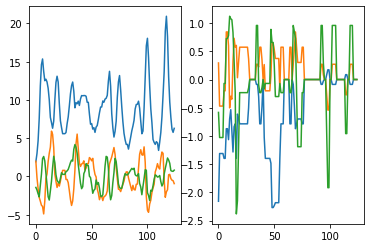

In [24]:
show_samples(X_train, y_train, n=1, is_random=False)

In [25]:
if (len(X_test) > 0):
    show_samples(X_test, y_test, n=1, is_random=False)
else:
    print("WARNING: there is no data in X_test. Are you using Bryan dataset as validation set?")

### Validation Set

Prepare the dataset

In [26]:
X_df, y_df = X_df_reference_validation.copy(), y_df_reference_validation.copy()

# Keep valid positions only
if USE_ALL_POSITION_BRYAN_DATASET:
    valid_positions_indicies = ~(y_df["position"] == "none") 
else:
    valid_positions_indicies = (y_df["position"] == "right") | (y_df["position"] == "left") | (y_df["position"] == "top") | (y_df["position"] == "back") | (y_df["position"] == "bottom")

# Filter out other data
X_df = X_df.loc[valid_positions_indicies]
y_df = y_df.loc[valid_positions_indicies]

# Shuffle data
X_df = X_df.sample(frac=1)
y_df = y_df.reindex(X_df.index)

Preprocess dataset

In [27]:
X_validation = get_X(X_df)
X_validation_centered = np.transpose(get_X(X_df, use_centering=True), (0, 2, 1))
y_validation = get_y(y_df)
y_validation_pos = get_y_pos(y_df)
y_validation_hot = get_y_hot(y_df)

In [28]:
X_validation_df = X_df.copy()
y_validation_df = y_df.copy()

del X_df, y_df

In [29]:
print(X_validation.shape)
print(y_validation.shape)
print(y_validation_hot.shape)

(4790, 6, 125)
(4790,)
(4790, 5)


X[0]: stairsdown


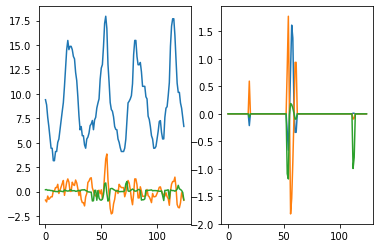

In [30]:
show_samples(X_validation, y_validation, n=1, is_random=False)

In [31]:
if USE_BRYAN_VALIDATION_DATASET:
    X_test = X_validation
    y_test = y_validation
    y_test_hot = y_validation_hot

X[0]: stairsdown


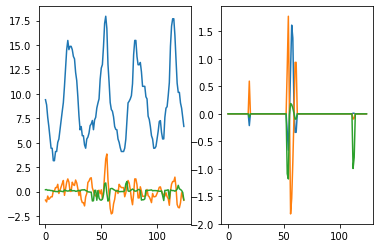

In [32]:
show_samples(X_test, y_test, n=1, is_random=False)

Check size

In [33]:
assert X_train.shape[0] == y_train.shape[0], f"Invalid shape for X_train and y_train: {X_train.shape} != {y_train.shape}"
assert X_test.shape[0] == y_test.shape[0], f"Invalid shape for X_test and y_test: {X_test.shape} != {y_test.shape}"
assert X_test.shape[0] == y_test.shape[0], f"Invalid shape for X_test and y_test: {X_test.shape} != {y_test.shape}"
assert y_train_hot.shape == (y_train.shape[0],num_classes), f"Invalid shape of y_train_hot: {y_train_hot.shape}"
assert y_test_hot.shape == (y_test.shape[0],num_classes), f"Invalid shape of y_test_hot: {y_test_hot.shape}"

## Data Exploration

### Training Set

In [34]:
print("Users", y_train_df["user"].unique())
print("Models", y_train_df["model"].unique())
print("Classes", y_train_df["label"].unique())

Users ['h' 'd' 'b' 'i' 'f' 'e' 'g' 'c' 'a']
Models ['s3_2' 's3mini_1' 'nexus4_2' 's3mini_2' 'nexus4_1' 's3_1']
Classes ['stairsdown' 'no_activity' 'walk' 'bike' 'stairsup']


Fraction of samples per label

In [35]:
print(y_train_df.groupby(["label"])["label"].count() / y_train_df["label"].count())

label
bike           0.135007
no_activity    0.370041
stairsdown     0.118417
stairsup       0.160147
walk           0.216388
Name: label, dtype: float64


Fraction of samples per user

In [36]:
print(y_train_df.groupby(["user"])["user"].count() / y_train_df["user"].count())

user
a    0.110123
b    0.108087
c    0.105558
d    0.109073
e    0.123883
f    0.094155
g    0.114988
h    0.112159
i    0.121975
Name: user, dtype: float64


Fraction of samples per model

In [37]:
print(y_train_df.groupby(["model"])["model"].count() / y_train_df["model"].count())

model
nexus4_1    0.195405
nexus4_2    0.207107
s3_1        0.191740
s3_2        0.199134
s3mini_1    0.198813
s3mini_2    0.007802
Name: model, dtype: float64


Number of samples per user i and fraction of samples per class for user i

In [38]:
y_df_i = y_train_df.loc[y_train_df["user"] == "i"]

num_samples_i = y_df_i["label"].count()
fraction_of_samples_per_class_i = y_df_i.groupby(["label"])["label"].count() / y_df_i["label"].count()

print(num_samples_i)
print(fraction_of_samples_per_class_i)

5691
label
bike           0.164119
no_activity    0.370058
stairsdown     0.128976
stairsup       0.109823
walk           0.227025
Name: label, dtype: float64


### Validation Set

In [39]:
print("Classes (validation)", y_validation_df["label"].unique())

Classes (validation) ['stairsdown' 'no_activity' 'walk' 'bike' 'stairsup']


In [40]:
print(y_validation_df.groupby(["label"])["label"].count() / y_validation_df["label"].count())

label
bike           0.242589
no_activity    0.241545
stairsdown     0.118998
stairsup       0.123591
walk           0.273278
Name: label, dtype: float64


In [41]:
print(y_validation_df.groupby(["user"])["user"].count() / y_validation_df["user"].count())

user
a    1.0
Name: user, dtype: float64


In [42]:
print(y_validation_df.groupby(["model"])["model"].count() / y_validation_df["model"].count())

model
oneplus_8t    1.0
Name: model, dtype: float64


# Demo

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [57]:
print(get_settings())

_oit_bryan_allpos


Prepare target classes

In [58]:
# Note: we cannot use scikit's label encoder due to the 
# fixed, non-sorted ordering of targets.

targets = ['no_activity','walk','bike','stairsup','stairsdown']

target_to_idx = lambda x: targets.index(x)
idx_to_target = lambda i: targets[i]

Load the model

In [66]:
model = tf.keras.models.load_model('./models/best_model_for_smartphone.h5')

Predict targets

In [67]:
preds = model.predict([X_validation_centered, X_validation])

In [68]:
y_pred = np.argmax(preds, axis=1)
y_true = np.array(list(map(target_to_idx, y_test)))

Classifications metrics

In [69]:
a = accuracy_score(y_true, y_pred)
p = precision_score(y_true, y_pred, average="weighted")
r = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"accuracy  = {a}")
print(f"precision = {p}")
print(f"recall    = {r}")
print(f"f1 score  = {f1}")

accuracy  = 0.7457202505219207
precision = 0.7734759377388244
recall    = 0.7457202505219207
f1 score  = 0.7377341915985388


In [70]:
print(classification_report(y_true, y_pred, target_names=targets))

              precision    recall  f1-score   support

 no_activity       1.00      0.99      0.99      1157
        walk       0.95      0.65      0.77      1309
        bike       0.60      0.86      0.71      1162
    stairsup       0.51      0.23      0.32       592
  stairsdown       0.53      0.76      0.63       570

    accuracy                           0.75      4790
   macro avg       0.72      0.70      0.68      4790
weighted avg       0.77      0.75      0.74      4790



Some classifications


walk classified as walk in right position


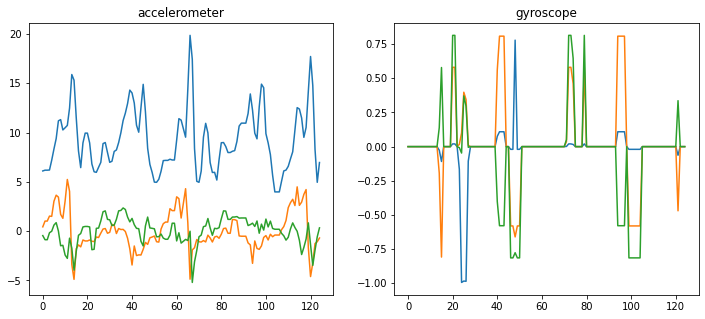


no_activity classified as no_activity in right position


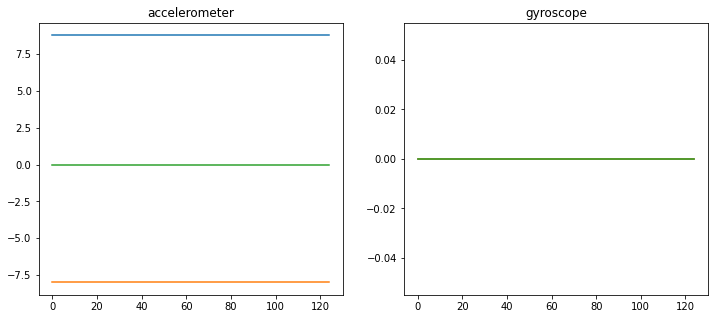


stairsup classified as bike in top position


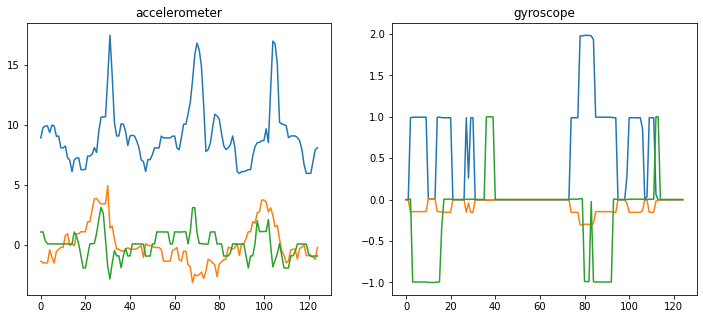


walk classified as walk in hand position


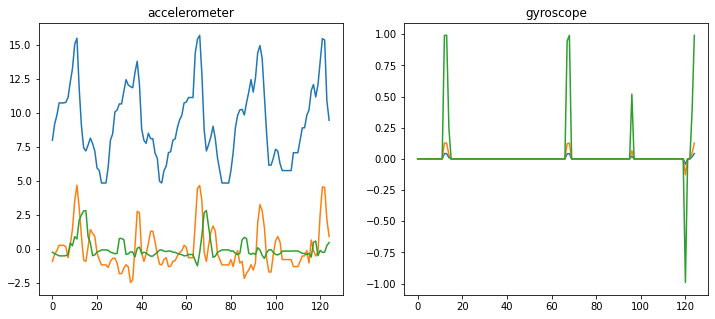


walk classified as walk in back position


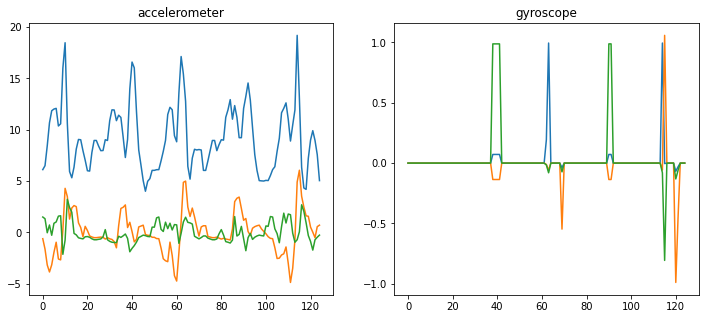


no_activity classified as no_activity in right position


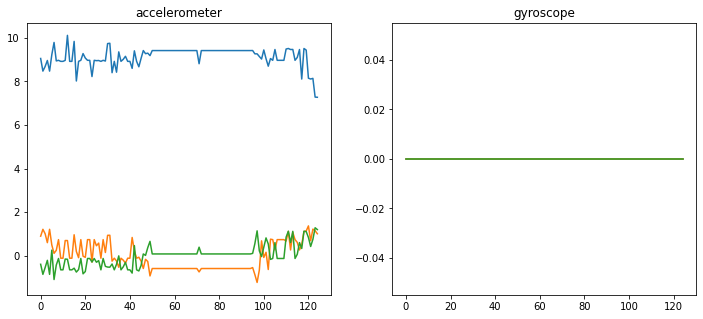


stairsdown classified as stairsdown in top position


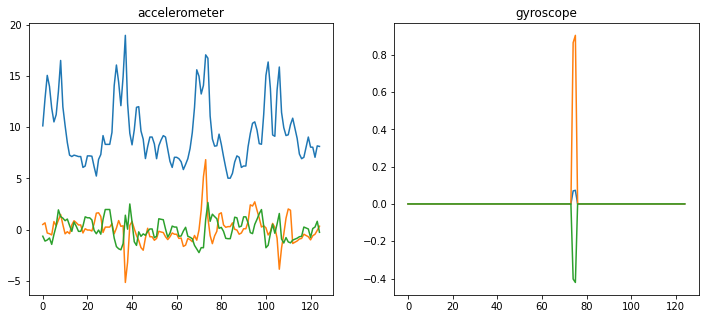


no_activity classified as no_activity in left position


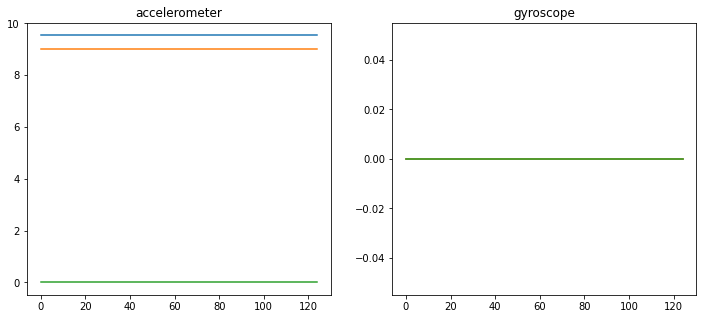


stairsup classified as bike in pocket-down position


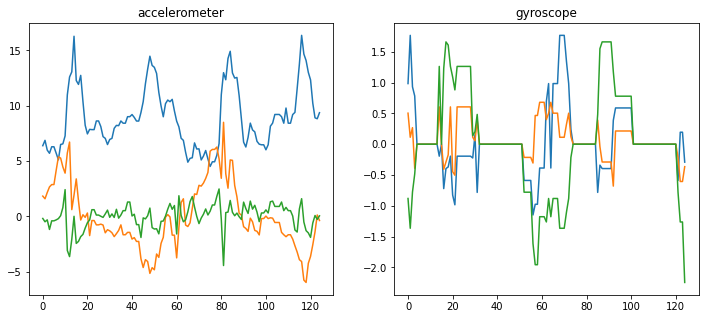


walk classified as bike in top position


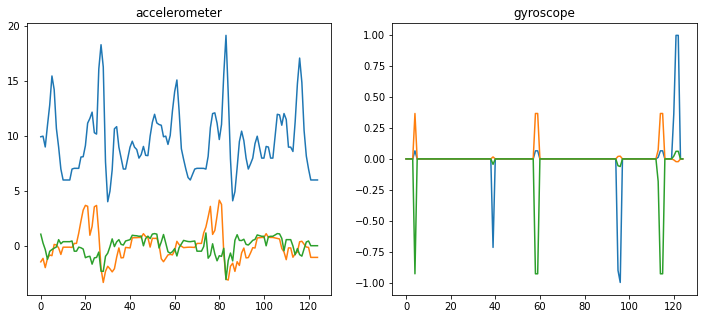


stairsdown classified as stairsdown in right position


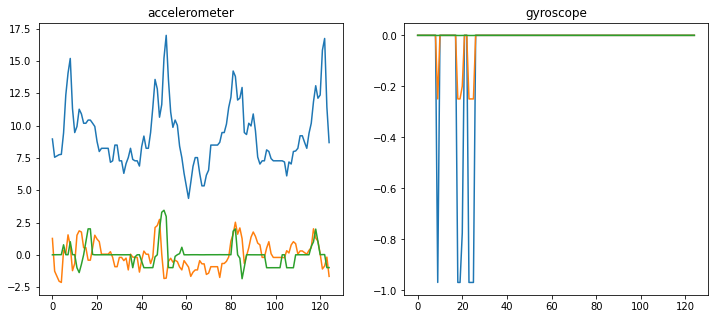


walk classified as bike in right position


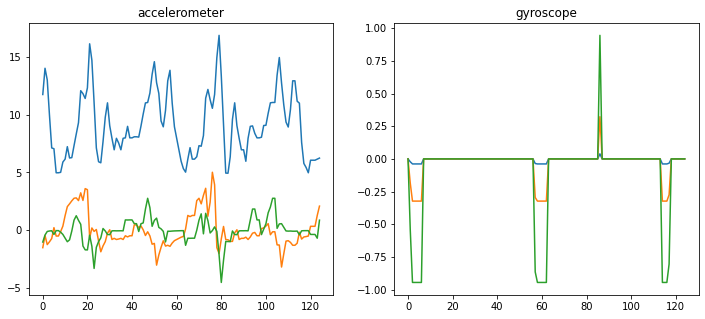


walk classified as walk in hand position


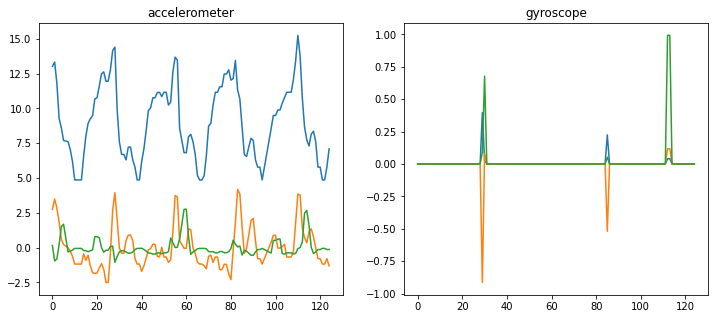


walk classified as bike in left position


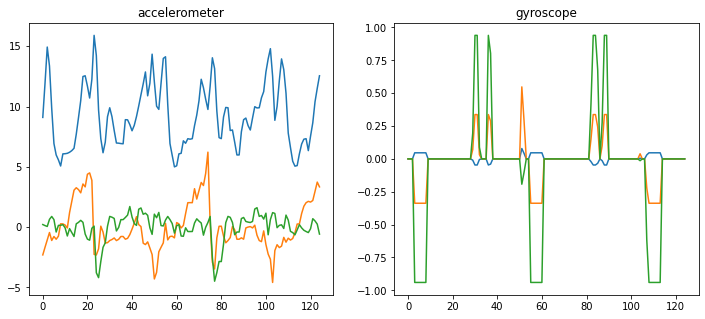


stairsdown classified as stairsdown in right position


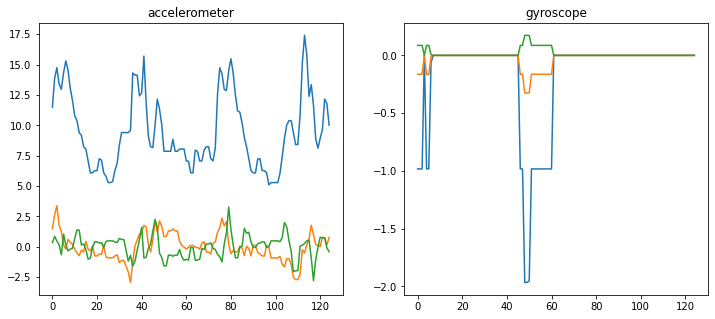


stairsdown classified as stairsup in pocket-down position


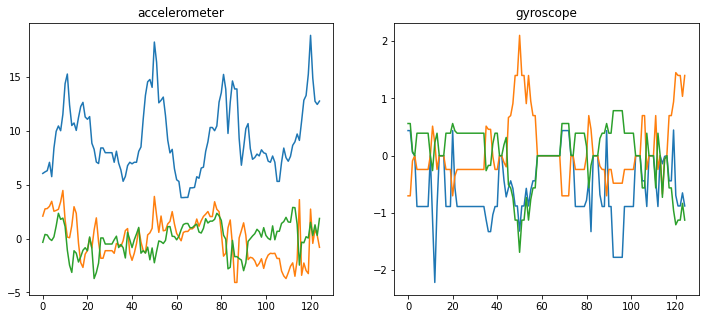


bike classified as bike in pocket-down position


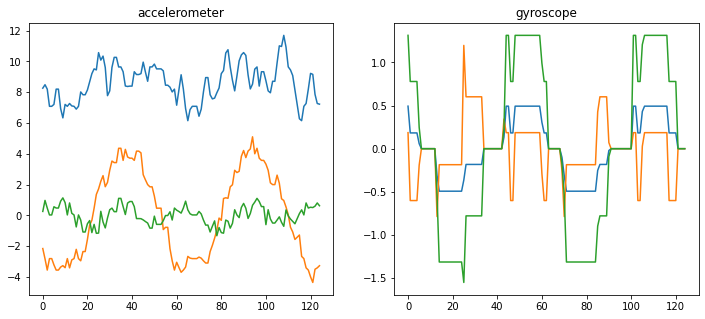


no_activity classified as no_activity in pocket-down position


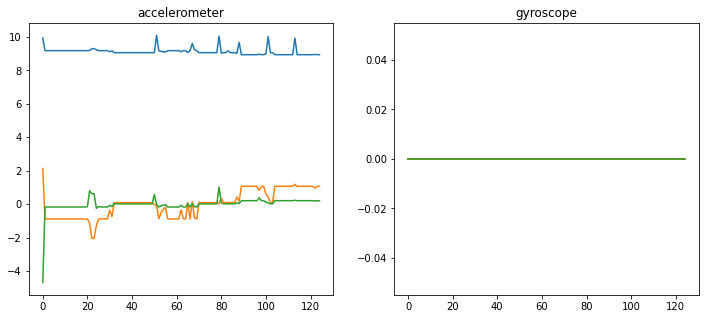


walk classified as walk in hand position


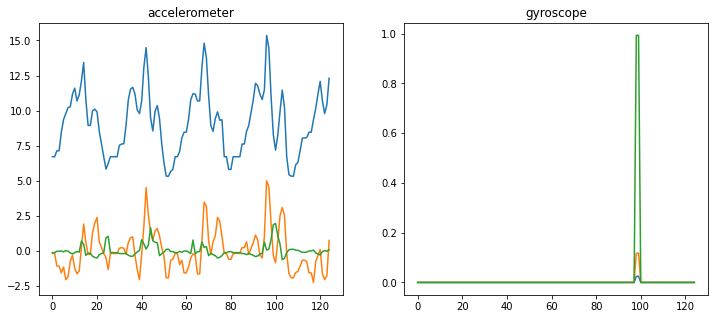


stairsdown classified as stairsdown in bottom position


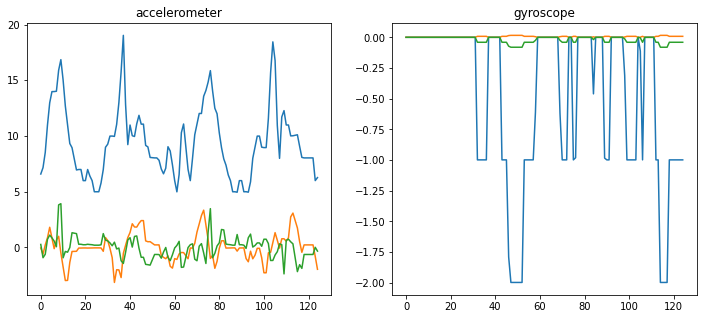

In [71]:
df = pd.DataFrame({"y_true": [idx_to_target(y) for y in y_true], "y_pred": [idx_to_target(y) for y in y_pred]})
sample_df = df.sample(20)

for index, row in sample_df.iterrows():

    true = row["y_true"]
    predicted = row["y_pred"]
    pos = y_validation_pos[index]

    print(f'\n{true} classified as {predicted} in {pos} position')

    data = X_validation[index]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("accelerometer")

    plt.plot(data[0])
    plt.plot(data[1])
    plt.plot(data[2])

    plt.subplot(1, 2, 2)
    plt.title("gyroscope")

    plt.plot(data[3])
    plt.plot(data[4])
    plt.plot(data[5])

    plt.show()

Confusion matrix

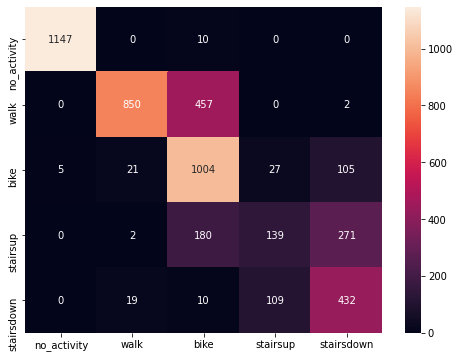

In [72]:
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(confusion, xticklabels=targets, yticklabels=targets, annot=True, fmt="d")
plt.show()